# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Jacopo De Stefani - __[Jacopo.De.Stefani@ulb.ac.be](mailto:Jacopo.De.Stefani@ulb.ac.be)__
### Théo Verhelst - __[Theo.Verhelst@ulb.ac.be](mailto:Theo.Verhelst@ulb.ac.be)__
### Gianluca Bontempi - __[gbonte@ulb.ac.be](mailto:gbonte@ulb.ac.be)__

## TP 5 - Ensembles of models and feature selection

####  April 20, 2021

#### Materials originally developed by *Yann-Aël Le Borgne, Fabrizio Carcillo and Gianluca Bontempi*

## Overview

Feature selection and ensembles of models are two techniques which can be used to improve the accuracy of preditions. 

Feature selection aims at reducing the dimensionality of the problem, and is useful when input variables contain redundant or irrelevant (noisy) information. Benefits are twofold: it decreases the training time by simplifying the problem, and it decreases the complexity of the predictive model. This in turn usually improves the prediction accuracy, since high-dimensionality makes predictive models more prone to overfitting, and estimates of parameters more variant. 

There are three main approaches to feature selection:
- **Filter methods:** 
These methods relies solely on the data and their intrinsic properties, without considering the impact of the selected features on the learning algorithm performance. For this reason, they are often used as preprocessing techniques.
- **Wrapper methods:** 
These methods assess subsets of variables according to their usefulness to a given predictor. The feature selection is perfomed using an evaluation function that includes the predictive performance of the consider learning algorithm as a selection criterion. 
- **Embedded methods:** 
These methods are specific to given learning machines, and usually built-in in the learning procedure (e.g. random forest, regularization based techniques).

Ensembles of models consist in building several predictive models using resampled subsets of the original training set. The method works particularly well for predictive models with high variance (for example, decision trees or neural networks). The average prediction of the resulting models usually strongly decreases the variance component of the error, and as a consequence improves the prediction accuracy. 

In this session, we will illustrate both techniques using the IMDB 5000 dataset, which contains 27 variables describing 5043 movies. The variables contain information about the director, actors, number of Facebook likes for each actor, duration, genre, language, country, etc... We will use them to predict the movie success (through the IMDB score). The dataset together with a description of the variables is at https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset.

The dataset is on the github of the course, in `5_EnsemblesFeatureSelection/movie_metadata.csv`

## Preliminaries

### Supervised learning

The process of supervised learning involves the presence of an entity (the learner, also called prediction model), whose goal is to learn the mapping between inputs and outputs in a given problem.

A supervised learning problem can formulated as follows:

\begin{equation*}
 y = m(\mathbf{x})  
\end{equation*}

where:
- $y$ represents the output variable (also called target)
- $\mathbf{x}$ represents the vector of inputs (also called features).
- $m$ is the (unknown) mapping between input and outputs.

In the majority of the supervised learning problems, the mapping $m$ between input and outputs is unknown and needs to be estimated on basis of the available input/output observation pairs $(\mathbf{x}_i,y_i)$.

## Classification vs regression

Both classification and regression are sub-fields of *supervised learning*. In the two cases, we have predictive variables $\mathbf{x}$ and a target variable $y$. 
The main difference betweet the two type of problems is the type of the target variabile:

- In classification, $y$ is a discrete variable; i.e $y \in \{C_1,\cdots,C_k\}$
- In regression, $y$ is a continuous variable; i.e $y \in \mathbb{R}$

In this practical, unlike the previous ones, we will tackle our problem as a regression problem, with the IMDB score being the continuous target variable to predict.


## Data overview and preprocessing

Let us load and select a random subset of 1000 movies

In [1]:
data<-read.csv("movie_metadata.csv",stringsAsFactors = T)
set.seed(2)
data<-data[sample(nrow(data),1000),]

### Dataset overview

In [2]:
dim(data)


[1] 1000   28

In [3]:
options(repr.matrix.max.cols=50)
data[1:2,]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
,<fct>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>
3925,Color,Oliver Stone,40,110,0,237,Zach Grenier,721,3468572,Drama,Michael Wincott,Talk RadioÂ,10073,1966,Bill Johnson,0,listener|neo nazi|radio|radio station|radio talk show,http://www.imdb.com/title/tt0096219/?ref_=fn_tt_tt_1,78,English,USA,R,4e+06,1988,246,7.3,1.85,816
4806,Color,Paul Fox,80,80,3,39,Jeff Seymour,108,NA,Horror|Thriller,Dov Tiefenbach,The Dark HoursÂ,4788,272,Gordon Currie,0,brain tumor|champagne|game|psychiatrist|weekend,http://www.imdb.com/title/tt0402249/?ref_=fn_tt_tt_1,52,English,Canada,R,5e+05,2005,64,6.1,1.85,166


In [4]:
summary(data)

              color              director_name num_critic_for_reviews
                 :  4                   : 24   Min.   :  1.0         
  Black and White: 37   Woody Allen     :  7   1st Qu.: 48.0         
 Color           :959   Bobby Farrelly  :  6   Median :103.0         
                        Barry Levinson  :  5   Mean   :135.1         
                        Chris Columbus  :  5   3rd Qu.:184.2         
                        Steven Spielberg:  5   Max.   :765.0         
                        (Other)         :948   NA's   :16            
    duration   director_facebook_likes actor_3_facebook_likes
 Min.   :  7   Min.   :    0.00        Min.   :    0.0       
 1st Qu.: 93   1st Qu.:    6.75        1st Qu.:  120.0       
 Median :103   Median :   44.00        Median :  395.0       
 Mean   :106   Mean   :  669.26        Mean   :  602.2       
 3rd Qu.:116   3rd Qu.:  204.75        3rd Qu.:  642.0       
 Max.   :511   Max.   :21000.00        Max.   :19000.0       
 NA's 

We see there is a mix of categorical and numerical variables, and some missing values. In order to simplify the analysis, let us remove the categorical variables, and replace the NA values with the mean values of the variables.

### Remove categorical variables

Check the type of input variables

In [5]:
sapply(data[1,],class)

color             director_name    num_critic_for_reviews 
                 "factor"                  "factor"                 "integer" 
                 duration   director_facebook_likes    actor_3_facebook_likes 
                "integer"                 "integer"                 "integer" 
             actor_2_name    actor_1_facebook_likes                     gross 
                 "factor"                 "integer"                 "integer" 
                   genres              actor_1_name               movie_title 
                 "factor"                  "factor"                  "factor" 
          num_voted_users cast_total_facebook_likes              actor_3_name 
                "integer"                 "integer"                  "factor" 
     facenumber_in_poster             plot_keywords           movie_imdb_link 
                "integer"                  "factor"                  "factor" 
     num_user_for_reviews                  language                   country 
                "integer"                  "factor"                  "factor" 
           content_rating                    budget                title_year 
                 "factor"                 "numeric"                 "integer" 
   actor_2_facebook_likes                imdb_score              aspect_ratio 
                "integer"                 "numeric"                 "numeric" 
     movie_facebook_likes 
                "integer"

Get indices of categorical (factor) variables

In [6]:
factor_variables_bool<-sapply(data[1,],class)=="factor"
factor_variables_bool

color             director_name    num_critic_for_reviews 
                     TRUE                      TRUE                     FALSE 
                 duration   director_facebook_likes    actor_3_facebook_likes 
                    FALSE                     FALSE                     FALSE 
             actor_2_name    actor_1_facebook_likes                     gross 
                     TRUE                     FALSE                     FALSE 
                   genres              actor_1_name               movie_title 
                     TRUE                      TRUE                      TRUE 
          num_voted_users cast_total_facebook_likes              actor_3_name 
                    FALSE                     FALSE                      TRUE 
     facenumber_in_poster             plot_keywords           movie_imdb_link 
                    FALSE                      TRUE                      TRUE 
     num_user_for_reviews                  language                   country 
                    FALSE                      TRUE                      TRUE 
           content_rating                    budget                title_year 
                     TRUE                     FALSE                     FALSE 
   actor_2_facebook_likes                imdb_score              aspect_ratio 
                    FALSE                     FALSE                     FALSE 
     movie_facebook_likes 
                    FALSE

In [7]:
factor_variables<-which(sapply(data[1,],class)=="factor")
factor_variables

color   director_name    actor_2_name          genres    actor_1_name 
              1               2               7              10              11 
    movie_title    actor_3_name   plot_keywords movie_imdb_link        language 
             12              15              17              18              20 
        country  content_rating 
             21              22

Remove categorical variables

In [8]:
data_preprocessed<-data[,-factor_variables]
summary(data_preprocessed)

 num_critic_for_reviews    duration   director_facebook_likes
 Min.   :  1.0          Min.   :  7   Min.   :    0.00       
 1st Qu.: 48.0          1st Qu.: 93   1st Qu.:    6.75       
 Median :103.0          Median :103   Median :   44.00       
 Mean   :135.1          Mean   :106   Mean   :  669.26       
 3rd Qu.:184.2          3rd Qu.:116   3rd Qu.:  204.75       
 Max.   :765.0          Max.   :511   Max.   :21000.00       
 NA's   :16             NA's   :4     NA's   :24             
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :    0          Min.   :      703  
 1st Qu.:  120.0        1st Qu.:  623          1st Qu.:  5003486  
 Median :  395.0        Median :  979          Median : 25025352  
 Mean   :  602.2        Mean   : 5951          Mean   : 46927291  
 3rd Qu.:  642.0        3rd Qu.:11000          3rd Qu.: 60549232  
 Max.   :19000.0        Max.   :49000          Max.   :658672302  
 NA's   :5              NA's   :3  

### Replace NA values with mean values

In [9]:
replace_na_with_mean_value<-function(vec) {
    mean_vec<-mean(vec,na.rm=T)
    vec[is.na(vec)]<-mean_vec
    vec
}

In [10]:
data_preprocessed<-data.frame(apply(data_preprocessed,2,replace_na_with_mean_value))
summary(data_preprocessed)

 num_critic_for_reviews    duration   director_facebook_likes
 Min.   :  1.0          Min.   :  7   Min.   :    0.0        
 1st Qu.: 48.0          1st Qu.: 93   1st Qu.:    7.0        
 Median :105.5          Median :103   Median :   48.5        
 Mean   :135.1          Mean   :106   Mean   :  669.3        
 3rd Qu.:181.0          3rd Qu.:116   3rd Qu.:  234.0        
 Max.   :765.0          Max.   :511   Max.   :21000.0        
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :    0.0        Min.   :      703  
 1st Qu.:  120.0        1st Qu.:  623.8        1st Qu.:  9158619  
 Median :  397.5        Median :  982.0        Median : 38108330  
 Mean   :  602.2        Mean   : 5950.9        Mean   : 46927291  
 3rd Qu.:  642.0        3rd Qu.:11000.0        3rd Qu.: 47159944  
 Max.   :19000.0        Max.   :49000.0        Max.   :658672302  
 num_voted_users  cast_total_facebook_likes facenumber_in_poster
 Min.   :     5   Min.   :    0 

### Input and output variables

The output variable (Y) is the `imdb_score`, and all other variables (X) are considered as inputs.

In [11]:
colnames(data_preprocessed)

[1] "num_critic_for_reviews"    "duration"                 
 [3] "director_facebook_likes"   "actor_3_facebook_likes"   
 [5] "actor_1_facebook_likes"    "gross"                    
 [7] "num_voted_users"           "cast_total_facebook_likes"
 [9] "facenumber_in_poster"      "num_user_for_reviews"     
[11] "budget"                    "title_year"               
[13] "actor_2_facebook_likes"    "imdb_score"               
[15] "aspect_ratio"              "movie_facebook_likes"

In [12]:
setdiff(colnames(data_preprocessed),"imdb_score")

[1] "num_critic_for_reviews"    "duration"                 
 [3] "director_facebook_likes"   "actor_3_facebook_likes"   
 [5] "actor_1_facebook_likes"    "gross"                    
 [7] "num_voted_users"           "cast_total_facebook_likes"
 [9] "facenumber_in_poster"      "num_user_for_reviews"     
[11] "budget"                    "title_year"               
[13] "actor_2_facebook_likes"    "aspect_ratio"             
[15] "movie_facebook_likes"

In [13]:
options(repr.plot.width=20, repr.plot.height=10)
set.seed(3)

X<-data_preprocessed[,setdiff(colnames(data_preprocessed),"imdb_score")]
Y<-data_preprocessed[,"imdb_score"]

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables


Distribution of the `imdb_score`

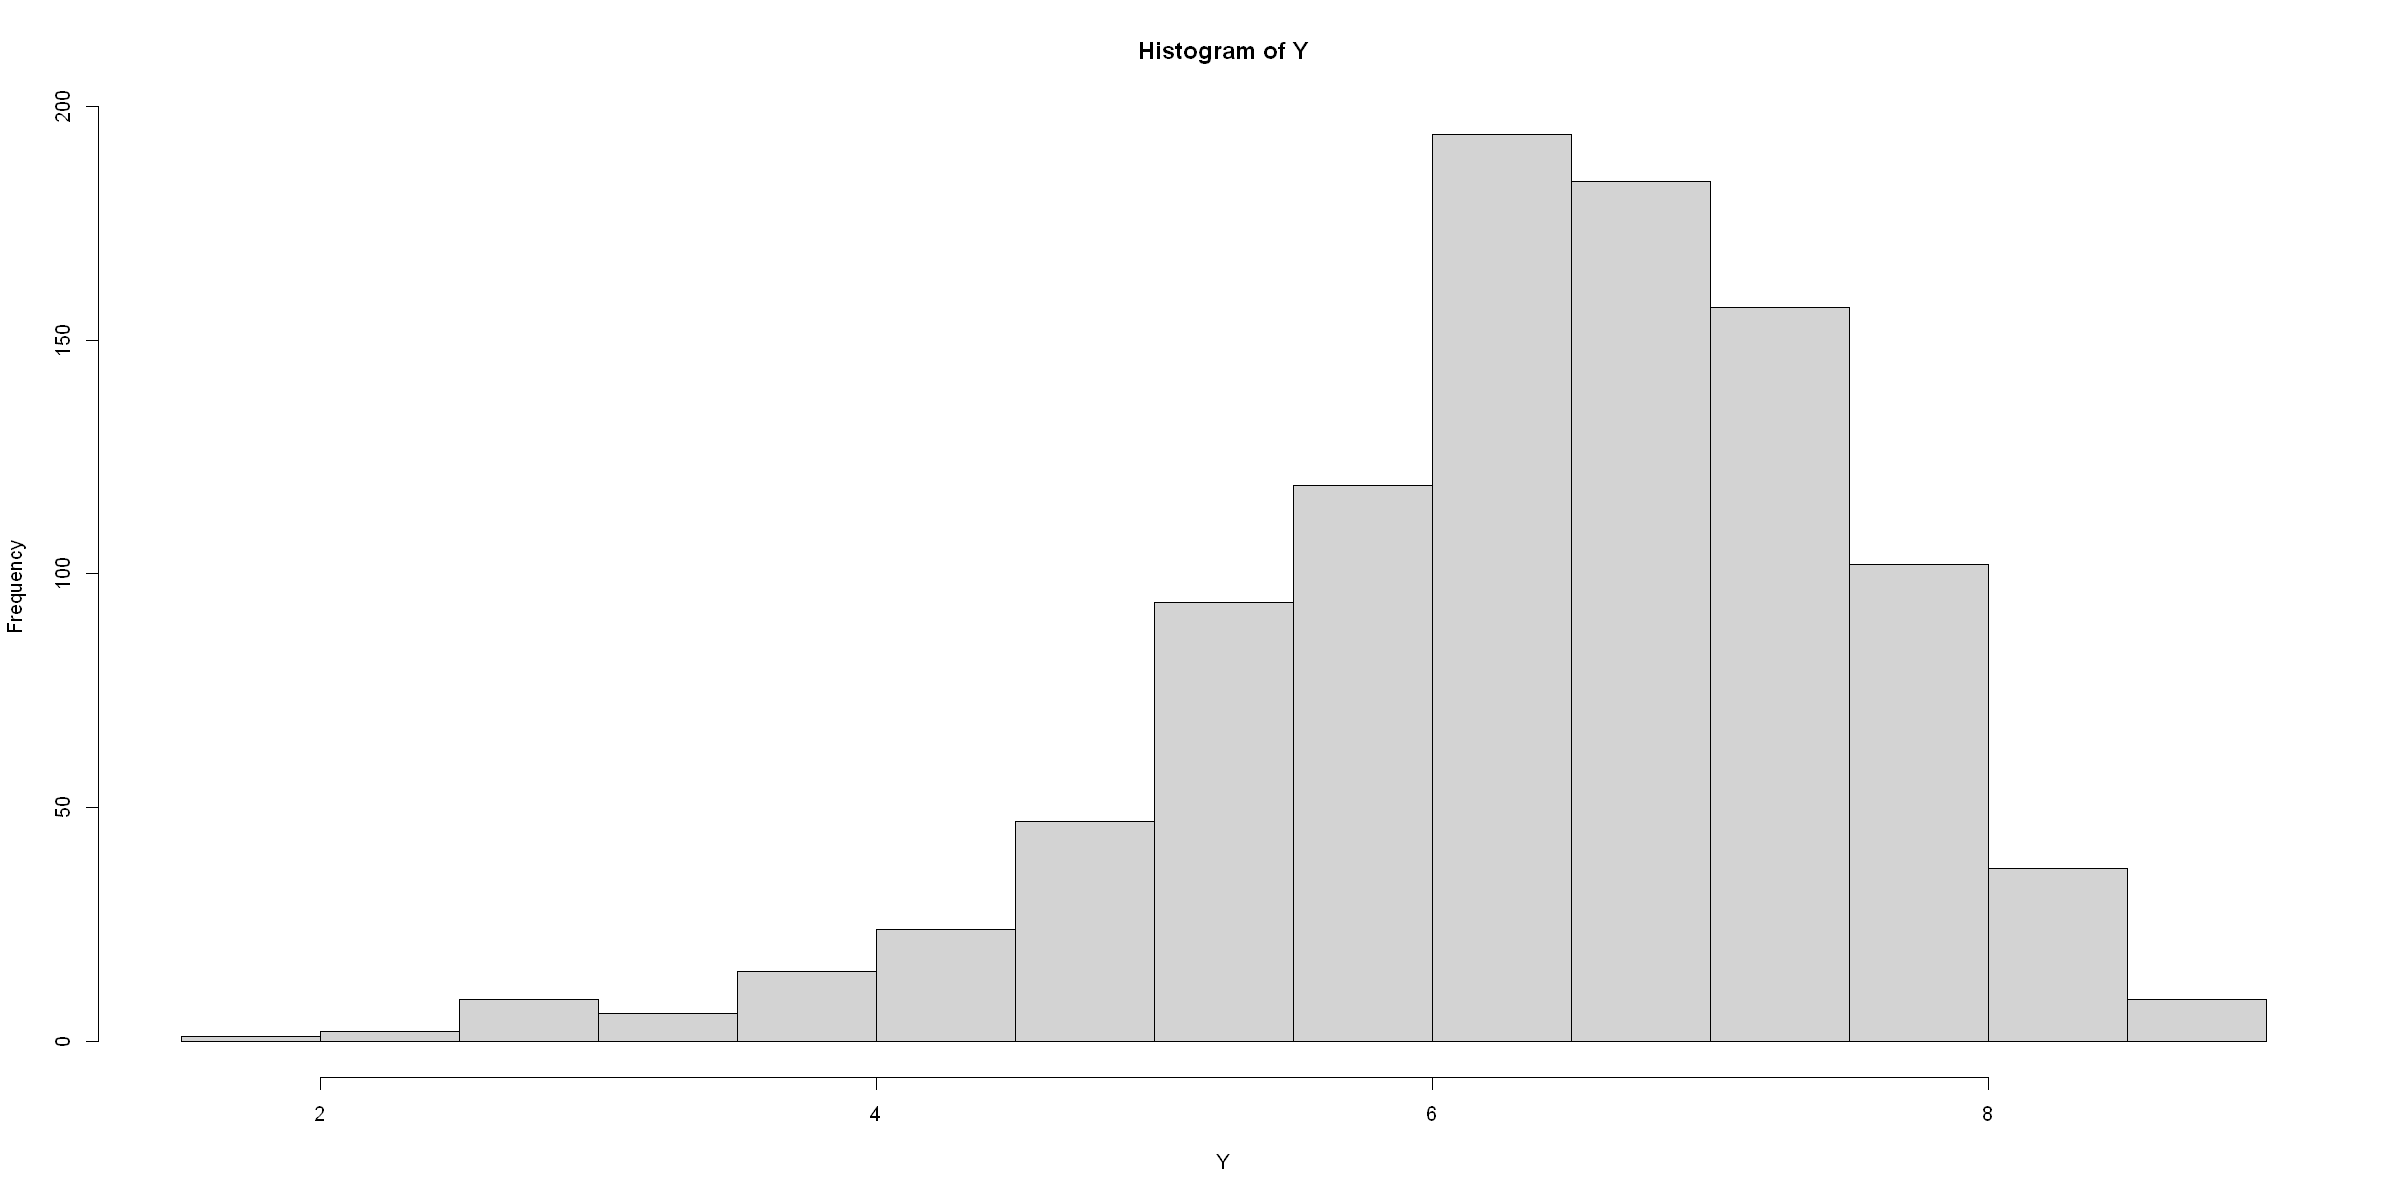

In [14]:
hist(Y)

In [15]:
mean(Y)

[1] 6.4255

In [16]:
var(Y)

[1] 1.246947

### 1) Modelling with linear and decision tree models

#### Linear model

* Let us create a linear model for predicting the IMDB score on the basis of the other variables, and compute its empricial mean square error

In [17]:
DS<-cbind(X,imdb_score=Y)
    
model<- lm(imdb_score~.,DS) ### Fill with your code here
        
Y_hat<- predict(model,X)
        
empirical_error<-mean((Y_hat-Y)^2) ### Fill with your code here

print(paste("Empirical error=",round(empirical_error,digits=4)))



[1] "Empirical error= 0.9084"


* Which input variables are statistically correlated with the output?

In [18]:
summary(model)


Call:
lm(formula = imdb_score ~ ., data = DS)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0647 -0.5016  0.0481  0.6020  2.7334 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                4.677e+01  5.394e+00   8.670  < 2e-16 ***
num_critic_for_reviews     2.123e-03  4.381e-04   4.845 1.47e-06 ***
duration                   4.324e-03  1.266e-03   3.416 0.000661 ***
director_facebook_likes   -1.463e-06  1.173e-05  -0.125 0.900836    
actor_3_facebook_likes     9.516e-05  5.313e-05   1.791 0.073619 .  
actor_1_facebook_likes     9.347e-05  3.055e-05   3.060 0.002275 ** 
gross                     -9.636e-10  7.420e-10  -1.299 0.194388    
num_voted_users            3.512e-06  5.086e-07   6.905 8.98e-12 ***
cast_total_facebook_likes -9.161e-05  2.964e-05  -3.091 0.002050 ** 
facenumber_in_poster      -1.959e-02  1.446e-02  -1.354 0.175903    
num_user_for_reviews      -3.360e-04  1.503e-04  -2.235 0.025667 *  
budget          

* Compute the validation error with a 10-fold cross-validation

In [19]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,imdb_score=Y_tr)
    
     # Model fit (using lm function)
     model<- lm(imdb_score~.,DS)
     
     # Model prediction 
     Y_hat_ts<- predict(model,X_ts)
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_lm_single_model <- CV_err

[1] "CV error= 0.9482  ; std dev= 0.1812"


#### Decision tree

* Modify the previous code to compute the empirical error using a decision tree model. Use the rpart package (see `?rpart` for help)

In [20]:
library(rpart)       ### Run install.packages("rpart") to install

Warning message:
"package 'rpart' was built under R version 4.0.4"


In [21]:
DS<-cbind(X,imdb_score=Y)

model<- rpart(imdb_score~.,DS) ### Fill with you code here
        
Y_hat<- predict(model,X)
        
empirical_error<-mean((Y_hat-Y)^2) 

print(paste("Empirical error=",round(empirical_error,digits=4)))



[1] "Empirical error= 0.6665"


* Plot the resulting tree using the `prp` function from the library `rpart.plot`

In [22]:
library(rpart.plot)  ### Run install.packages("rpart.plot") to install

Warning message:
"package 'rpart.plot' was built under R version 4.0.5"


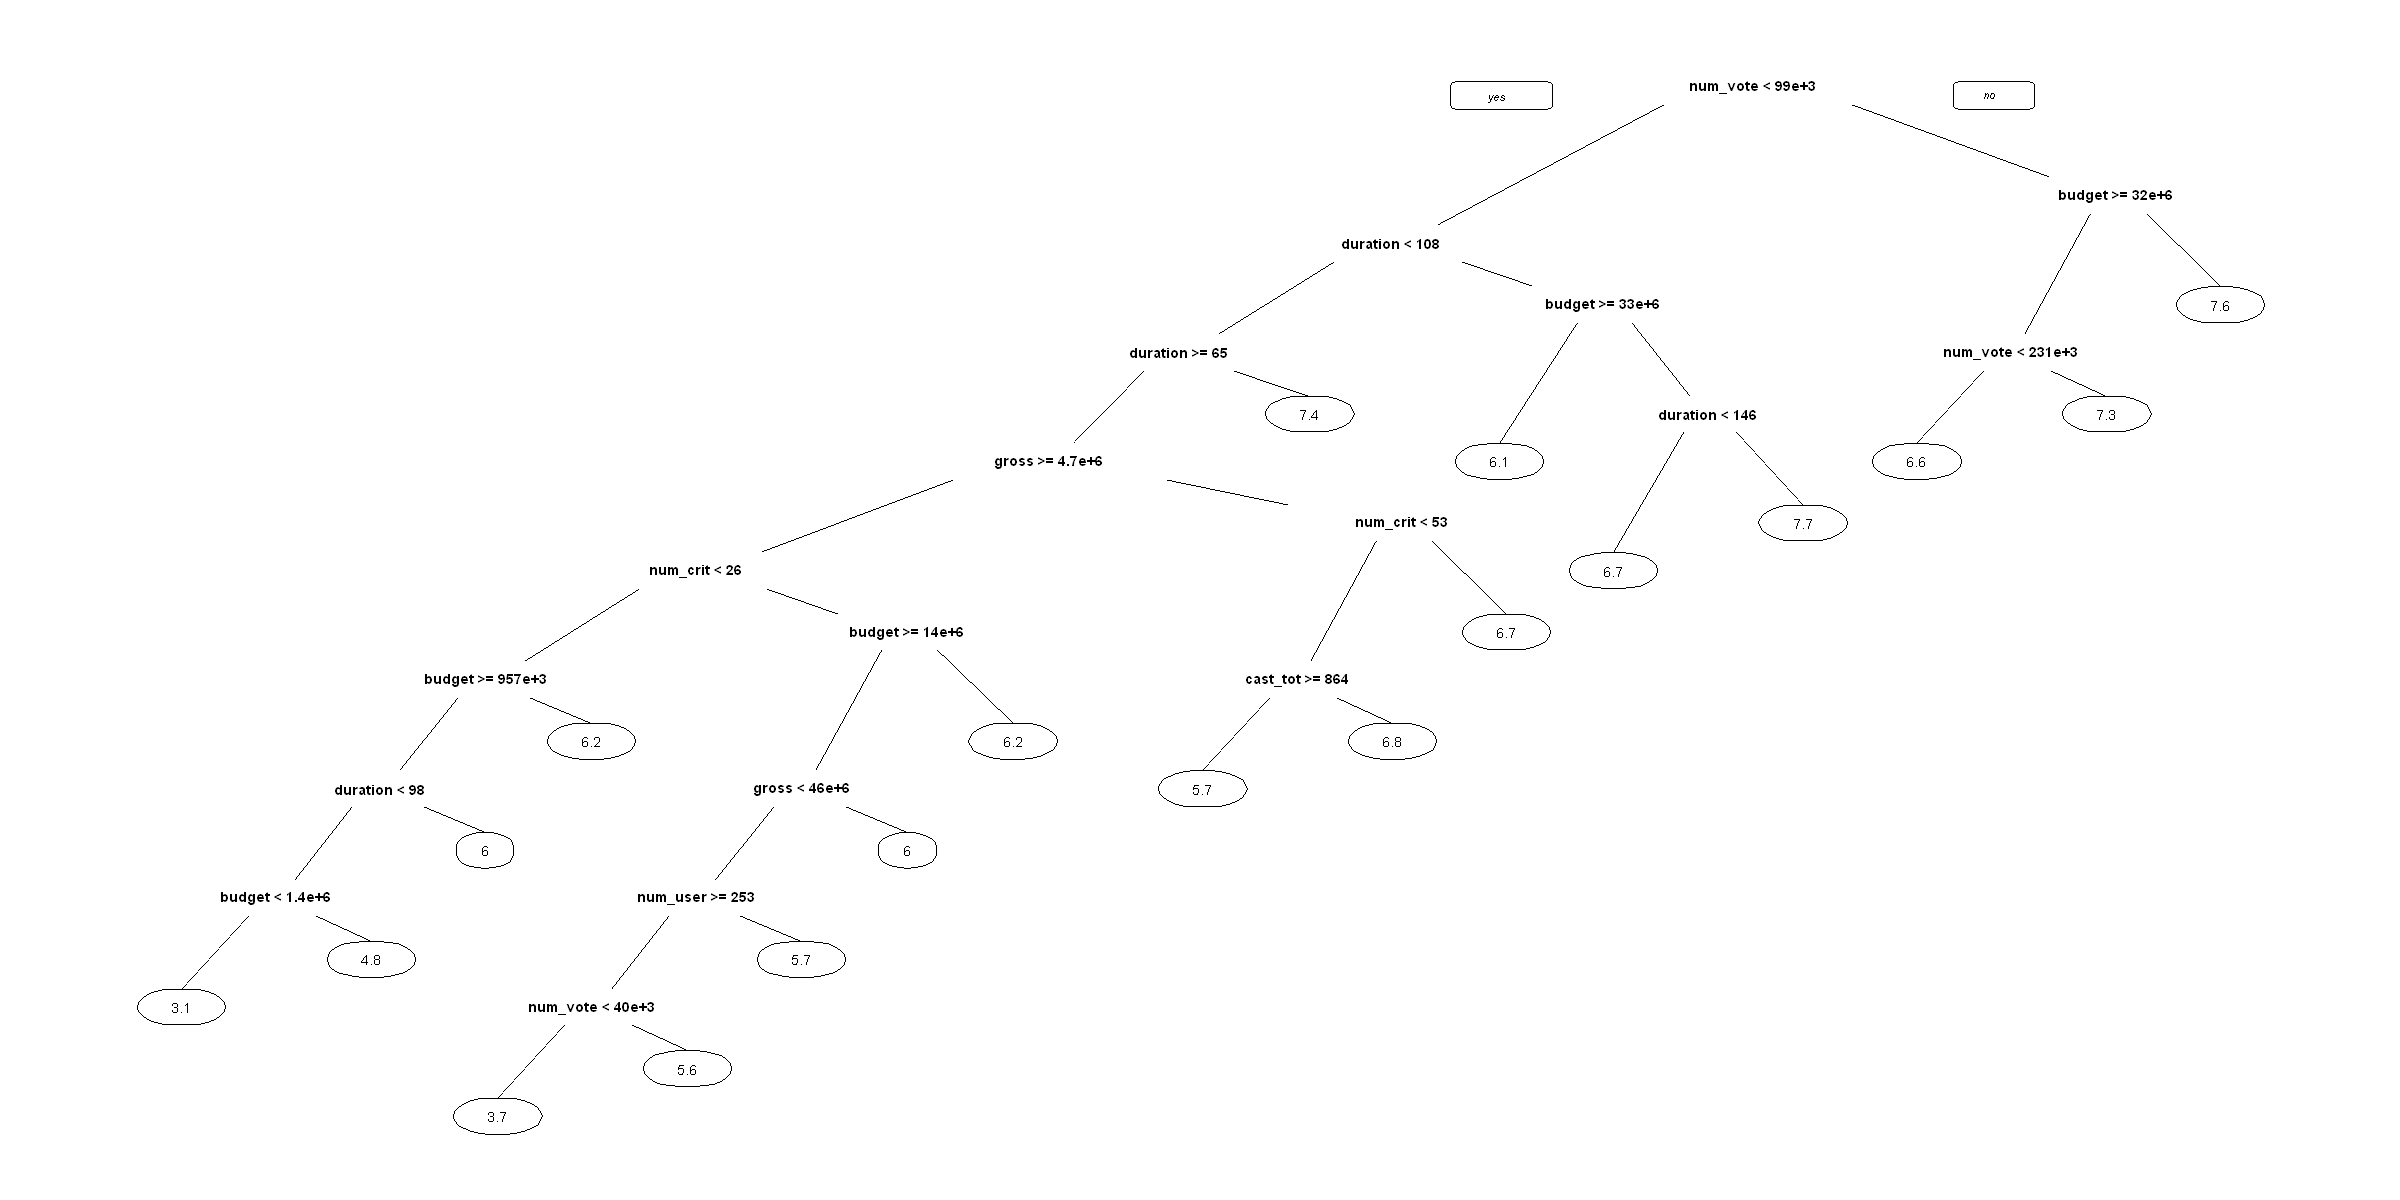

In [23]:
prp(model)

* What is the 10-fold cross-validation error using a decision tree model?

In [24]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,imdb_score=Y_tr)
    
     # Model fit (using rpart function)
     model<- rpart(imdb_score~.,DS)
     
     # Model prediction 
     Y_hat_ts<- predict(model,X_ts)
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_rpart_single_model <- CV_err

[1] "CV error= 0.9657  ; std dev= 0.1711"


## 2) Ensemble of models

Let us now create an ensemble of $R$ linear models to make predictions. Complete the code below so that:

* The training set is resampled before building a model
* The predictions of all model are averaged before testing

In [25]:
CV_folds <- 10
R<-20

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
    # The predictions of each individual model is stored as
    # a column of the Y_hat_ts_ensemble matrix
     Y_hat_ts_ensemble <- matrix(0,nrow=nrow(X_ts),ncol=R) 
      
     for (r in 1:R) {
         idx_tr_resample <- sample(idx_tr,rep=T)
         X_tr<-X[idx_tr_resample,]
         Y_tr<-Y[idx_tr_resample]                          
     
         DS<-cbind(X_tr,imdb_score=Y_tr)
    
         # Model fit (using lm function)
         model<- lm(imdb_score~.,DS)
        
         # Storing prediction for the r^th model
         Y_hat_ts_ensemble[,r]<- predict(model,X_ts)
     
     }
    
     #Computing ensemble prediction (via model averaging)
     Y_hat_ts<-apply(Y_hat_ts_ensemble,1,mean)
    
     # Computation of CV error = MSE
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
     }

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_lm_ensemble_model <- CV_err

[1] "CV error= 0.9511  ; std dev= 0.1811"


* Is the CV error lower than with a single linear model?

In [26]:
mean(CV_err_lm_ensemble_model) < mean(CV_err_lm_single_model)

[1] FALSE

* Use a decision tree as the base model. Is the CV error lower?

In [27]:
CV_folds <- 10
R<-20

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
    # The predictions of each individual model is stored as
    # a column of the Y_hat_ts_ensemble matrix
     Y_hat_ts_ensemble <- matrix(0,nrow=nrow(X_ts),ncol=R) 
      
     for (r in 1:R) {
         idx_tr_resample <- sample(idx_tr,rep=T)
         X_tr<-X[idx_tr_resample,]
         Y_tr<-Y[idx_tr_resample]                          
     
         DS<-cbind(X_tr,imdb_score=Y_tr)
    
         # Model fit (using rpart function)
         model<- rpart(imdb_score~.,DS)
        
         # Storing prediction for the r^th model
         Y_hat_ts_ensemble[,r]<- predict(model,X_ts)
     
     }
    
     #Computing ensemble prediction (via model averaging)
     Y_hat_ts<-apply(Y_hat_ts_ensemble,1,mean)
    
     # Computation of CV error = MSE
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
     }

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_rpart_ensemble_model <- CV_err

[1] "CV error= 0.7982  ; std dev= 0.1428"


* Is the CV error lower than with a single tree-based model?

In [28]:
mean(CV_err_rpart_ensemble_model) < mean(CV_err_rpart_single_model)

[1] TRUE

## 3) Feature selection

Two are the main approaches to feature selection:


* **Filter methods:** they are preprocessing methods. They attempt to
assess the merits of features from the data, ignoring the effects of
the selected feature subset on the performance of the learning
algorithm. Examples are methods that select variables by ranking them
through compression techniques (like PCA), or by computing correlation or a more advanced similarity measure such as minimum redundancy maximum relevance (mRMR) with the output.

*  **Wrapper methods:** these methods assess subsets of variables
according to their usefulness to a given predictor. The method
conducts a search for a good subset using the learning algorithm
itself as part of the evaluation function. The problem boils 
down to a problem of stochastic state space search. Example
are the stepwise methods proposed in linear regression analysis.



### Filter methods

#### Correlation with the output

* The following code performs features selection by keeping the most correlated variables with the output. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?


In [29]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],imdb_score=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(imdb_score~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))


 [1] "#Features:  1  ; CV error= 1.047  ; std dev= 0.1913"  
 [2] "#Features:  2  ; CV error= 1.0434  ; std dev= 0.1879" 
 [3] "#Features:  3  ; CV error= 1.0388  ; std dev= 0.1879" 
 [4] "#Features:  4  ; CV error= 1.0422  ; std dev= 0.1869" 
 [5] "#Features:  5  ; CV error= 1.0216  ; std dev= 0.1637" 
 [6] "#Features:  6  ; CV error= 0.9628  ; std dev= 0.1894" 
 [7] "#Features:  7  ; CV error= 0.9532  ; std dev= 0.1825" 
 [8] "#Features:  8  ; CV error= 0.9542  ; std dev= 0.1837" 
 [9] "#Features:  9  ; CV error= 0.9567  ; std dev= 0.1822" 
[10] "#Features:  10  ; CV error= 0.9493  ; std dev= 0.1862"
[11] "#Features:  11  ; CV error= 0.9522  ; std dev= 0.1864"
[12] "#Features:  12  ; CV error= 0.9595  ; std dev= 0.1825"
[13] "#Features:  13  ; CV error= 0.9547  ; std dev= 0.1869"
[14] "#Features:  14  ; CV error= 0.9519  ; std dev= 0.1845"
[15] "#Features:  15  ; CV error= 0.9482  ; std dev= 0.1812"


In [30]:
correlation_ranking_idx
colnames(X)[correlation_ranking_idx]

[1]  7  1 15 10  2 12  6  5  8 13  3  9 11  4 14

[1] "num_voted_users"           "num_critic_for_reviews"   
 [3] "movie_facebook_likes"      "num_user_for_reviews"     
 [5] "duration"                  "title_year"               
 [7] "gross"                     "actor_1_facebook_likes"   
 [9] "cast_total_facebook_likes" "actor_2_facebook_likes"   
[11] "director_facebook_likes"   "facenumber_in_poster"     
[13] "budget"                    "actor_3_facebook_likes"   
[15] "aspect_ratio"

#### mRMR

* The following code performs features selection by using the mRMR approach (Section 12.8 - Syllabus). Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?


In [31]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],imdb_score=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(imdb_score~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Features:  1  ; CV error= 1.047  ; std dev= 0.1913"  
 [2] "#Features:  2  ; CV error= 0.9989  ; std dev= 0.2005" 
 [3] "#Features:  3  ; CV error= 0.9906  ; std dev= 0.1899" 
 [4] "#Features:  4  ; CV error= 0.9931  ; std dev= 0.1916" 
 [5] "#Features:  5  ; CV error= 0.9844  ; std dev= 0.1883" 
 [6] "#Features:  6  ; CV error= 0.987  ; std dev= 0.1886"  
 [7] "#Features:  7  ; CV error= 0.9895  ; std dev= 0.1873" 
 [8] "#Features:  8  ; CV error= 0.9842  ; std dev= 0.1875" 
 [9] "#Features:  9  ; CV error= 0.9672  ; std dev= 0.1856" 
[10] "#Features:  10  ; CV error= 0.9679  ; std dev= 0.1861"
[11] "#Features:  11  ; CV error= 0.9604  ; std dev= 0.1774"
[12] "#Features:  12  ; CV error= 0.9601  ; std dev= 0.178" 
[13] "#Features:  13  ; CV error= 0.9586  ; std dev= 0.1817"
[14] "#Features:  14  ; CV error= 0.9525  ; std dev= 0.181" 
[15] "#Features:  15  ; CV error= 0.9482  ; std dev= 0.1812"


In [32]:
selected
colnames(X)[selected]

[1]  7 12  2  9 15 10 14  3  1 13  5  6  4  8 11

[1] "num_voted_users"           "title_year"               
 [3] "duration"                  "facenumber_in_poster"     
 [5] "movie_facebook_likes"      "num_user_for_reviews"     
 [7] "aspect_ratio"              "director_facebook_likes"  
 [9] "num_critic_for_reviews"    "actor_2_facebook_likes"   
[11] "actor_1_facebook_likes"    "gross"                    
[13] "actor_3_facebook_likes"    "cast_total_facebook_likes"
[15] "budget"

#### PCA

* The following code performs features selection by first transforming the inputs using PCA, and then keeping the most relevant principal components in the model. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?



In [33]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

# Compute PCA on the full input dataset X and return the dataset transformed in the space of principal components
X_pca<-data.frame(prcomp(X,retx=T)$x)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_pca[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_pca[idx_tr,]
    Y_tr<-Y[idx_tr]         
     
    for (nb_components in 1:n) {
        # Create a dataset including only the first nb_components principal components
        DS<-cbind(X_tr[,1:nb_components,drop=F],imdb_score=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(imdb_score~.,DS)
        
        # Model predict
        Y_hat_ts<- predict(model,X_ts[,1:nb_components,drop=F])
        
        CV_err[nb_components,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))


 [1] "#Features:  1  ; CV error= 1.2239  ; std dev= 0.2165" 
 [2] "#Features:  2  ; CV error= 1.2183  ; std dev= 0.2192" 
 [3] "#Features:  3  ; CV error= 1.022  ; std dev= 0.181"   
 [4] "#Features:  4  ; CV error= 1.0209  ; std dev= 0.181"  
 [5] "#Features:  5  ; CV error= 1.0224  ; std dev= 0.1802" 
 [6] "#Features:  6  ; CV error= 1.0234  ; std dev= 0.1801" 
 [7] "#Features:  7  ; CV error= 1.028  ; std dev= 0.1782"  
 [8] "#Features:  8  ; CV error= 1.0258  ; std dev= 0.1823" 
 [9] "#Features:  9  ; CV error= 1.026  ; std dev= 0.1815"  
[10] "#Features:  10  ; CV error= 1.0281  ; std dev= 0.1826"
[11] "#Features:  11  ; CV error= 1.0199  ; std dev= 0.1797"
[12] "#Features:  12  ; CV error= 0.9892  ; std dev= 0.1607"
[13] "#Features:  13  ; CV error= 0.9447  ; std dev= 0.1834"
[14] "#Features:  14  ; CV error= 0.946  ; std dev= 0.1851" 
[15] "#Features:  15  ; CV error= 0.9482  ; std dev= 0.1812"


### Wrapper method: Forward selection

* The following code performs features selection by using a forward selection method (Section 12.4 - Syllabus). Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?


In [34]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X[idx_tr,features_to_include,drop=F]
            Y_tr<-Y[idx_tr]         
            
            # Create a dataset including only the first nb_components principal components
            DS<-cbind(X_tr,imdb_score=Y_tr)
        
            # Model fit (using lm function)
            model<- lm(imdb_score~.,DS)
        
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
     
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
        }
        
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV_err_mean[selected_current],digits=4), " ; std dev=",round(CV_err_sd[selected_current],digits=4)))

}
                   


[1] "Round  1  ; Selected feature:  7  ; CV error= 1.047  ; std dev= 0.1913"
[1] "Round  2  ; Selected feature:  12  ; CV error= 0.9989  ; std dev= 0.2005"
[1] "Round  3  ; Selected feature:  1  ; CV error= 0.9778  ; std dev= 0.2045"
[1] "Round  4  ; Selected feature:  11  ; CV error= 0.9578  ; std dev= 0.2026"
[1] "Round  5  ; Selected feature:  2  ; CV error= 0.9479  ; std dev= 0.1903"
[1] "Round  6  ; Selected feature:  10  ; CV error= 0.942  ; std dev= 0.1851"
[1] "Round  7  ; Selected feature:  4  ; CV error= 0.9419  ; std dev= 0.1871"
[1] "Round  8  ; Selected feature:  13  ; CV error= 0.9407  ; std dev= 0.1907"
[1] "Round  9  ; Selected feature:  9  ; CV error= 0.941  ; std dev= 0.1929"
[1] "Round  10  ; Selected feature:  6  ; CV error= 0.9416  ; std dev= 0.1889"
[1] "Round  11  ; Selected feature:  15  ; CV error= 0.9427  ; std dev= 0.1897"
[1] "Round  12  ; Selected feature:  8  ; CV error= 0.944  ; std dev= 0.1901"
[1] "Round  13  ; Selected feature:  5  ; CV error= 0.9427  

In [35]:
colnames(X)[selected]

[1] "num_voted_users"           "title_year"               
 [3] "num_critic_for_reviews"    "budget"                   
 [5] "duration"                  "num_user_for_reviews"     
 [7] "actor_3_facebook_likes"    "actor_2_facebook_likes"   
 [9] "facenumber_in_poster"      "gross"                    
[11] "movie_facebook_likes"      "cast_total_facebook_likes"
[13] "actor_1_facebook_likes"    "aspect_ratio"             
[15] "director_facebook_likes"

## Further preprocessing to add categorical variables

Categorical variables usually need to be transformed with 'one-hot-encoding' in order to be processed by a learning algorithm. That is, for each value of the categorical variable, a binary feature is created, which is set to one whenever that value is present. This can be done using the `dummy.data.frame` of the `dummies` package.

```
install.packages('dummies')
library(dummies)
```

In the following, we add some categorical variables to the peprocessing dataset. The set of categorical variables is

In [ ]:
install.packages('dummies')
library(dummies)

In [37]:
factor_variables

color   director_name    actor_2_name          genres    actor_1_name 
              1               2               7              10              11 
    movie_title    actor_3_name   plot_keywords movie_imdb_link        language 
             12              15              17              18              20 
        country  content_rating 
             21              22

Let us have an overview of the their content

In [38]:
data_factor<-data[,factor_variables]

In [39]:
dim(data_factor)

[1] 1000   12

In [40]:
data_factor[1:2,]

,color,director_name,actor_2_name,genres,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,country,content_rating
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
3925,Color,Oliver Stone,Zach Grenier,Drama,Michael Wincott,Talk RadioÂ,Bill Johnson,listener|neo nazi|radio|radio station|radio talk show,http://www.imdb.com/title/tt0096219/?ref_=fn_tt_tt_1,English,USA,R
4806,Color,Paul Fox,Jeff Seymour,Horror|Thriller,Dov Tiefenbach,The Dark HoursÂ,Gordon Currie,brain tumor|champagne|game|psychiatrist|weekend,http://www.imdb.com/title/tt0402249/?ref_=fn_tt_tt_1,English,Canada,R


Let us keep four of them: Color, language, country and content_rating, and transform them with one-hot-encoding

In [41]:
variables_to_keep<-c("color","language","country","content_rating")

In [42]:
data_factor_onehot <- dummy.data.frame(data_factor[,variables_to_keep], sep="_")
# Concerning the warnings: https://stackoverflow.com/questions/56637183/warning-message-dummy-from-dummies-package

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"


In [43]:
dim(data_factor_onehot)

[1] 1000   82

In [44]:
data_factor_onehot[1:2,]

,color_,color_ Black and White,color_Color,language_,language_Aboriginal,language_Arabic,language_Cantonese,language_Danish,language_Dari,language_Dutch,language_Dzongkha,language_English,language_French,language_German,language_Hebrew,language_Hindi,language_Icelandic,language_Italian,language_Kazakh,language_Mandarin,language_Norwegian,language_Panjabi,language_Persian,language_Polish,language_Portuguese,...,country_South Africa,country_South Korea,country_Soviet Union,country_Spain,country_Switzerland,country_UK,country_United Arab Emirates,country_USA,content_rating_,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_Passed,content_rating_PG,content_rating_PG-13,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-MA,content_rating_TV-PG,content_rating_Unrated,content_rating_X
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
3925,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4806,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


These could be added to the previously preprocessed dataset, and used to further improve the prediction accuracy using the feature selection/ensemble techniques seen above. 

In [45]:
data_preprocessed_extended<-cbind(data_preprocessed,data_factor_onehot)

In [46]:
dim(data_preprocessed_extended)

[1] 1000   98

In [47]:
summary(data_preprocessed_extended)

 num_critic_for_reviews    duration   director_facebook_likes
 Min.   :  1.0          Min.   :  7   Min.   :    0.0        
 1st Qu.: 48.0          1st Qu.: 93   1st Qu.:    7.0        
 Median :105.5          Median :103   Median :   48.5        
 Mean   :135.1          Mean   :106   Mean   :  669.3        
 3rd Qu.:181.0          3rd Qu.:116   3rd Qu.:  234.0        
 Max.   :765.0          Max.   :511   Max.   :21000.0        
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :    0.0        Min.   :      703  
 1st Qu.:  120.0        1st Qu.:  623.8        1st Qu.:  9158619  
 Median :  397.5        Median :  982.0        Median : 38108330  
 Mean   :  602.2        Mean   : 5950.9        Mean   : 46927291  
 3rd Qu.:  642.0        3rd Qu.:11000.0        3rd Qu.: 47159944  
 Max.   :19000.0        Max.   :49000.0        Max.   :658672302  
 num_voted_users  cast_total_facebook_likes facenumber_in_poster
 Min.   :     5   Min.   :    0 

## Using other predictive models

Other models could be used, for example support vector machines, neural networks, K-nearest neighbors (using the `svm`, `nnt`or `lazy` functions from the `e1071`, `nnet` or `lazy` packages, respectively). Note that scaling the data is usually necessary when using neural networks and K-nearest neighbors approaches.

Is the usage of different models improving the predictive performance?

In [ ]:
install.packages(c("e1071","nnet","lazy"))

In [49]:
X<-data_preprocessed_extended[,setdiff(colnames(data_preprocessed_extended),"imdb_score")]
Y<-data_preprocessed_extended[,"imdb_score"]

colnames(X) <- gsub(colnames(X),pattern = " ", replacement = "_")
colnames(X) <- gsub(colnames(X),pattern = "-", replacement = "_")

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables


In [50]:
dim(X)
length(Y)

[1] 1000   97

[1] 1000

In [51]:
library(e1071)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,imdb_score=Y_tr)
    
     # Model fit (using lm function)
     model<- svm(imdb_score~.,DS)
     
     # Model prediction 
     Y_hat_ts<- predict(model,X_ts)
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_svm_single_model <- CV_err

Warning message:
"package 'e1071' was built under R version 4.0.5"
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'language_Icelandic' and 'language_Polish' and 'country_Iceland' and 'country_Panama' and 'country_Poland' constant. Cannot scale data."
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'country_South_Africa' and 'country_Soviet_Union' and 'country_Switzerland' constant. Cannot scale data."
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'country_Slovakia' constant. Cannot scale data."
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'language_Dari' and 'language_Hebrew' and 'country_Afghanistan' constant. Cannot scale data."
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'language_Kazakh' and 'language_Romanian' and 'country_Romania' constant. Can

[1] "CV error= 1.2294  ; std dev= 0.2539"


In [52]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10
n_variables <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n_variables,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n_variables) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n_variables) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],imdb_score=Y_tr)
        
        # Model fit (using lm function)
        model<- svm(imdb_score~.,DS)
     
        # Model prediction 
        Y_hat_ts<- predict(model,X_ts)
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n_variables)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

CV_err_svm_single_model_fs <- CV_err

Warning message in cor(X_tr, Y_tr):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning mes

 [1] "#Features:  1  ; CV error= 1.0429  ; std dev= 0.1948" 
 [2] "#Features:  2  ; CV error= 1.0392  ; std dev= 0.2102" 
 [3] "#Features:  3  ; CV error= 1.0216  ; std dev= 0.2077" 
 [4] "#Features:  4  ; CV error= 1.0183  ; std dev= 0.2057" 
 [5] "#Features:  5  ; CV error= 0.9436  ; std dev= 0.1987" 
 [6] "#Features:  6  ; CV error= 0.9177  ; std dev= 0.2176" 
 [7] "#Features:  7  ; CV error= 0.8822  ; std dev= 0.1769" 
 [8] "#Features:  8  ; CV error= 0.8725  ; std dev= 0.1572" 
 [9] "#Features:  9  ; CV error= 0.8679  ; std dev= 0.1512" 
[10] "#Features:  10  ; CV error= 0.8644  ; std dev= 0.1478"


In [53]:
library(nnet)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,imdb_score=Y_tr/10) # The output variable is rescaled to be in 0-1 range
    
     # Model fit (using nnet function)
     model <- nnet(imdb_score ~ .,DS,skip=FALSE,
                       size=10, maxit=5000,trace=F,rang=0.2,MaxNWts=10000)
     
     # Model prediction (multiplied by 10 to rescale (0,1) -> (0,10))
     Y_hat_ts<- predict(model,X_ts)*10
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_nnet_single_model <- CV_err

Warning message:
"package 'nnet' was built under R version 4.0.5"


[1] "CV error= 1.2316  ; std dev= 0.21"


In [54]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10
n_variables <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n_variables,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n_variables) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n_variables) {
        # Create a dataset including only the first nb_features selected variables
        # The output variable is rescaled to be in 0-1 range
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],imdb_score=Y_tr/10)
        
        # Model fit (using nnet function)
        model <- nnet(imdb_score ~ .,DS,skip=FALSE,
                       size=10, maxit=500,trace=F,rang=0.2,MaxNWts=10000)
     
        # Model prediction (multiplied by 10 to rescale (0,1) -> (0,10))
        Y_hat_ts<- predict(model,X_ts)*10
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n_variables)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

CV_err_nnet_single_model_fs <- CV_err

Warning message in cor(X_tr, Y_tr):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning mes

 [1] "#Features:  1  ; CV error= 1.0992  ; std dev= 0.2409" 
 [2] "#Features:  2  ; CV error= 1.1306  ; std dev= 0.1908" 
 [3] "#Features:  3  ; CV error= 1.1262  ; std dev= 0.1337" 
 [4] "#Features:  4  ; CV error= 1.1357  ; std dev= 0.2034" 
 [5] "#Features:  5  ; CV error= 1.0928  ; std dev= 0.2276" 
 [6] "#Features:  6  ; CV error= 1.1739  ; std dev= 0.2394" 
 [7] "#Features:  7  ; CV error= 1.129  ; std dev= 0.1959"  
 [8] "#Features:  8  ; CV error= 1.0872  ; std dev= 0.1539" 
 [9] "#Features:  9  ; CV error= 1.151  ; std dev= 0.1369"  
[10] "#Features:  10  ; CV error= 1.1299  ; std dev= 0.1466"


In [55]:
library(lazy)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-numeric(CV_folds)

for (i in 1:CV_folds) {
     idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
     X_ts<-X[idx_ts,]  
     Y_ts<-Y[idx_ts]  
     
     idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
     X_tr<-X[idx_tr,]
     Y_tr<-Y[idx_tr]                          
     
     DS<-cbind(X_tr,imdb_score=Y_tr)
    
     # Model fit (using lm function)
     model<- lazy(imdb_score~.,DS)
     
     # Model prediction 
     Y_hat_ts<- predict(model,X_ts)$h
     
     # Cross validation error = Mean Squared Error
     CV_err[i]<-mean((Y_hat_ts-Y_ts)^2)
}
    

print(paste("CV error=",round(mean(CV_err),digits=4), " ; std dev=",round(sd(CV_err),digits=4)))

CV_err_lazy_single_model <- CV_err

[1] "CV error= 1.14682710043345e+23  ; std dev= 2.56427269671226e+23"


In [56]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10
n_variables <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n_variables,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n_variables) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n_variables) {
        # Create a dataset including only the first nb_features selected variables
        # The output variable is rescaled to be in 0-1 range
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],imdb_score=Y_tr)
        
        # Model fit (using lazy function)
        model<- lazy(imdb_score~.,DS)
     
        # Model prediction 
        Y_hat_ts<- predict(model,X_ts)$h
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n_variables)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

CV_err_lazy_single_model_fs <- CV_err

Warning message in cor(X_tr, Y_tr):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning message in cor(X_tr[, selected, drop = F], X_tr[, candidates, drop = F]):
"the standard deviation is zero"
Warning mes

 [1] "#Features:  1  ; CV error= 1.2513  ; std dev= 0.2353"
 [2] "#Features:  2  ; CV error= 1.3941  ; std dev= 0.3082"
 [3] "#Features:  3  ; CV error= 1.4098  ; std dev= 0.3334"
 [4] "#Features:  4  ; CV error= 1.5571  ; std dev= 0.455" 
 [5] "#Features:  5  ; CV error= 1.5288  ; std dev= 0.3827"
 [6] "#Features:  6  ; CV error= 1.4941  ; std dev= 0.3574"
 [7] "#Features:  7  ; CV error= 1.6003  ; std dev= 0.4762"
 [8] "#Features:  8  ; CV error= 1.5657  ; std dev= 0.5639"
 [9] "#Features:  9  ; CV error= 1.568  ; std dev= 0.5733" 
[10] "#Features:  10  ; CV error= 1.6602  ; std dev= 0.655"
